In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Add, Input, ZeroPadding2D, AveragePooling2D,SpatialDropout2D
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Path where our data is located
base_path = "C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/Datasets/ASL_Data_Preprocessed/asl_data_train_processed/"

# Dictionary to save our 36 classes
categories = {  0: "0",
                1: "1",
                2: "2",
                3: "3",
                4: "4",
                5: "5",
                6: "6",
                7: "7",
                8: "8",
                9: "9",
                10: "a",
                11: "b",
                12: "c",
                13: "d",
                14: "e",
                15: "f",
                16: "g",
                17: "h",
                18: "i",
                19: "j",
                20: "k",
                21: "l",
                22: "m",
                23: "n",
                24: "o",
                25: "p",
                26: "q",
                27: "r",
                28: "s",
                29: "t",
                30: "u",
                31: "v",
                32: "w",
                33: "x",
                34: "y",
                35: "z",
            }

def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(
        lambda x: x[re.search("_", x).start() + 1 : re.search("_", x).start() + 2]
        + "/"
        + x
    )
    return df


# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    filenames_list = filenames_list + filenames
    categories_list = categories_list + [category] * len(filenames)

df = pd.DataFrame({"category": categories_list})
# df = add_class_name_prefix(df, "filename")

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)
df

,category
0,13
1,28
2,27
3,4
4,14
...,...
35995,6
35996,30
35997,18
35998,21


In [3]:
# Image paths
train_dir = 'C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/Datasets/ASL_Data_Preprocessed/asl_data_train_processed'
test_dir = 'C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/Datasets/ASL_Data_Preprocessed/asl_data_test_processed'

# image dimensions and batch size
img_width, img_height = 200, 200
batch_size = 32
target_dimensions = (img_width, img_height, 3) ##64x64 RGB
# Function to create metadata
def create_metadata(data_dir):
    metadata = []
    for category in os.listdir(data_dir):
        category_dir = os.path.join(data_dir, category)
        category_images = os.listdir(category_dir)
        for filename in category_images:
            filepath = os.path.join(category_dir, filename)
            metadata.append({'filepath': filepath, 'label': category})
    return metadata

#metadata for train and test data
train_metadata = create_metadata(train_dir)
test_metadata = create_metadata(test_dir)

# Converting metadata to DataFrame
train_metadata_df = pd.DataFrame(train_metadata)
test_metadata_df = pd.DataFrame(test_metadata)

In [4]:
print(test_metadata_df)

                                                filepath label
0      C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/...     0
1      C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/...     0
2      C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/...     0
3      C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/...     0
4      C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/...     0
...                                                  ...   ...
14395  C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/...     Z
14396  C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/...     Z
14397  C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/...     Z
14398  C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/...     Z
14399  C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/...     Z

[14400 rows x 2 columns]


In [5]:
# image dimensions and batch size
img_width, img_height = 200, 200
IMG_SIZE = (200, 200)
batch_size = 32
target_dimensions = (img_width, img_height, 3) ##64x64 RGB

In [6]:
# Split dataset into training and test sets
train_data, val_data = train_test_split(train_metadata_df, test_size=0.2, random_state=42)

# Create data generators for training, validation, and test sets
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='filepath',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='filepath',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_metadata_df,
    x_col='filepath',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle= False,
    class_mode='categorical')

Found 28800 validated image filenames belonging to 36 classes.
Found 7200 validated image filenames belonging to 36 classes.
Found 14400 validated image filenames belonging to 36 classes.


In [7]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer

    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = f, strides = 1, padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    # Third component of main path

    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X

In [8]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer,
                   also called Xavier uniform initializer.

    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = f, strides = 1, padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s,s), padding = 'valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [9]:
def ResNet50(input_shape = (200, 200, 3), classes = 36):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = SpatialDropout2D(0.4)(X)
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    # Stage 3
    X = SpatialDropout2D(0.4)(X)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4
    X = SpatialDropout2D(0.4)(X)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5
    X = SpatialDropout2D(0.4)(X)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    X = AveragePooling2D((2,2))(X)
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)


    model = Model(inputs = X_input, outputs = X)

    return model
model = ResNet50(input_shape = (200, 200, 3), classes = 36)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 206, 206, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 100, 100, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [11]:
early_stoping = EarlyStopping(monitor='val_loss', 
                              min_delta=0.001,
                              patience= 5,
                              restore_best_weights= True, 
                              verbose = 0)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy', 
                                         patience = 2, 
                                         factor=0.5 , 
                                         verbose = 1)

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
history = model.fit(train_generator, 
                      validation_data= val_generator, 
                      epochs=10, 
                      callbacks=[early_stoping,reduce_learning_rate],
                      verbose = 1)

Epoch 1/10
900/900 [==============================] - 261s 278ms/step - loss: 2.5888 - accuracy: 0.3317 - val_loss: 1.1385 - val_accuracy: 0.6421 - lr: 0.0010
Epoch 2/10
900/900 [==============================] - 245s 272ms/step - loss: 0.6751 - accuracy: 0.7911 - val_loss: 0.4075 - val_accuracy: 0.8779 - lr: 0.0010
Epoch 3/10
900/900 [==============================] - 245s 272ms/step - loss: 0.3979 - accuracy: 0.8757 - val_loss: 0.3143 - val_accuracy: 0.9065 - lr: 0.0010
Epoch 4/10
900/900 [==============================] - 262s 291ms/step - loss: 0.2916 - accuracy: 0.9098 - val_loss: 0.2333 - val_accuracy: 0.9312 - lr: 0.0010
Epoch 5/10
900/900 [==============================] - 247s 274ms/step - loss: 0.2359 - accuracy: 0.9265 - val_loss: 0.2049 - val_accuracy: 0.9371 - lr: 0.0010
Epoch 6/10
900/900 [==============================] - 248s 275ms/step - loss: 0.1772 - accuracy: 0.9435 - val_loss: 0.1863 - val_accuracy: 0.9440 - lr: 0.0010
Epoch 7/10
900/900 [==========================

In [14]:
# Evaluvate for train generator
loss,acc = model.evaluate(train_generator , verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

The accuracy of the model for training data is: 97.88888692855835
The Loss of the model for training data is: 0.06793326139450073


In [15]:
# Evaluvate for validation generator
loss,acc = model.evaluate(val_generator, verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

The accuracy of the model for validation data is: 96.94444537162781
The Loss of the model for validation data is: 0.10366426408290863


In [16]:
# Evaluvate for test generator
loss,acc = model.evaluate(test_generator, verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

The accuracy of the model for validation data is: 83.38194489479065
The Loss of the model for validation data is: 0.914857029914856


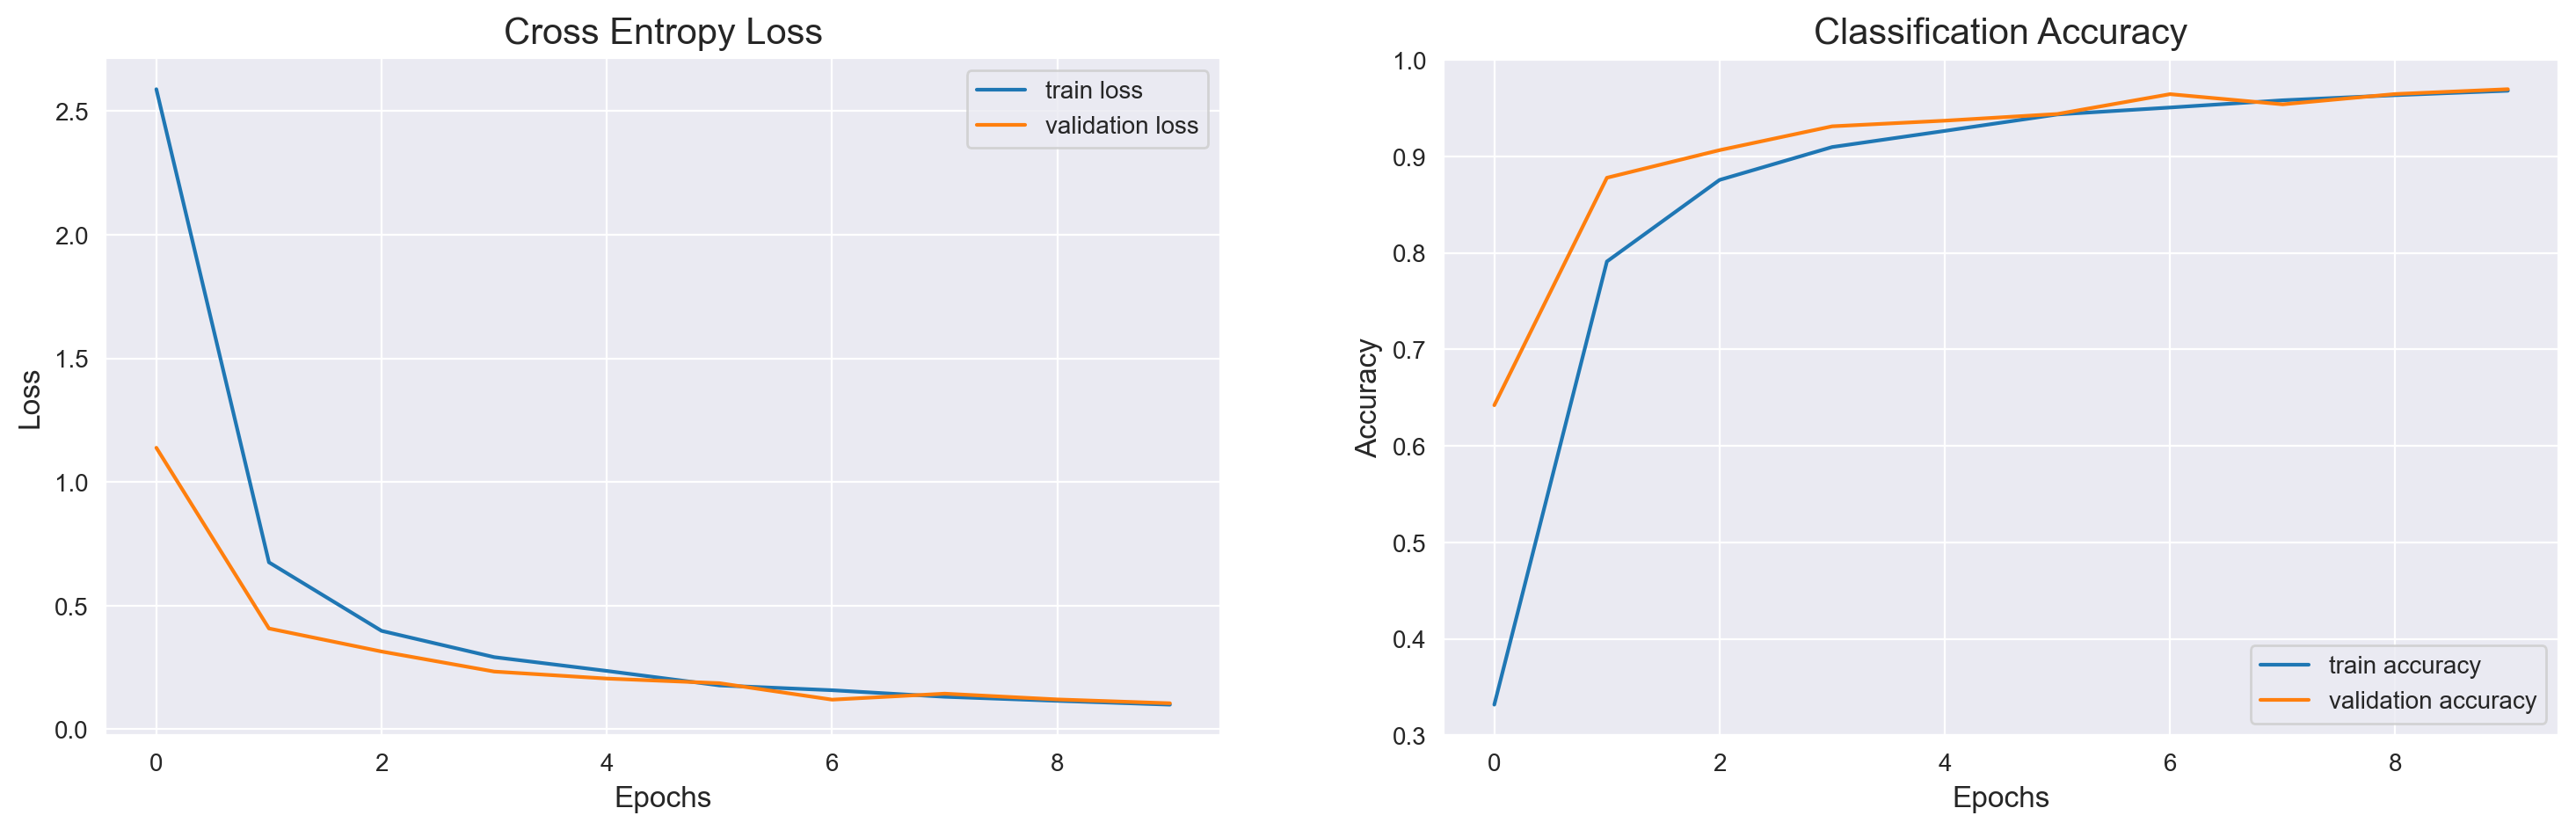

In [17]:
# plots for accuracy and Loss with epochs
error = pd.DataFrame(history.history)
plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])
plt.legend(['train loss', 'validation loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])
plt.legend(['train accuracy', 'validation accuracy'])
plt.show()

In [18]:
# prediction
result = model.predict(test_generator,verbose = 0)

y_pred = np.argmax(result, axis = 1)

y_true = test_generator.labels

# Evaluvate
loss,acc = model.evaluate(test_generator,verbose = 0)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

The accuracy of the model for testing data is: 83.38194489479065
The Loss of the model for testing data is: 0.914857029914856


In [19]:
p = y_pred
y = y_true
correct = np.nonzero(p==y)[0]
incorrect = np.nonzero(p!=y)[0]

print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 12007
Incorrect predicted classes: 2393


In [20]:
print(classification_report(y_true, y_pred,target_names= categories.values()))

              precision    recall  f1-score   support

           0       0.46      0.87      0.60       400
           1       0.93      0.88      0.91       400
           2       0.89      0.94      0.91       400
           3       0.83      0.98      0.90       400
           4       0.97      0.94      0.95       400
           5       0.99      0.88      0.93       400
           6       0.91      0.96      0.93       400
           7       0.95      0.94      0.95       400
           8       0.95      0.95      0.95       400
           9       0.91      0.94      0.93       400
           a       0.96      0.78      0.86       400
           b       0.84      0.82      0.83       400
           c       0.94      0.85      0.89       400
           d       0.90      0.89      0.89       400
           e       0.85      0.77      0.81       400
           f       0.74      0.88      0.80       400
           g       0.86      0.93      0.90       400
           h       0.99    

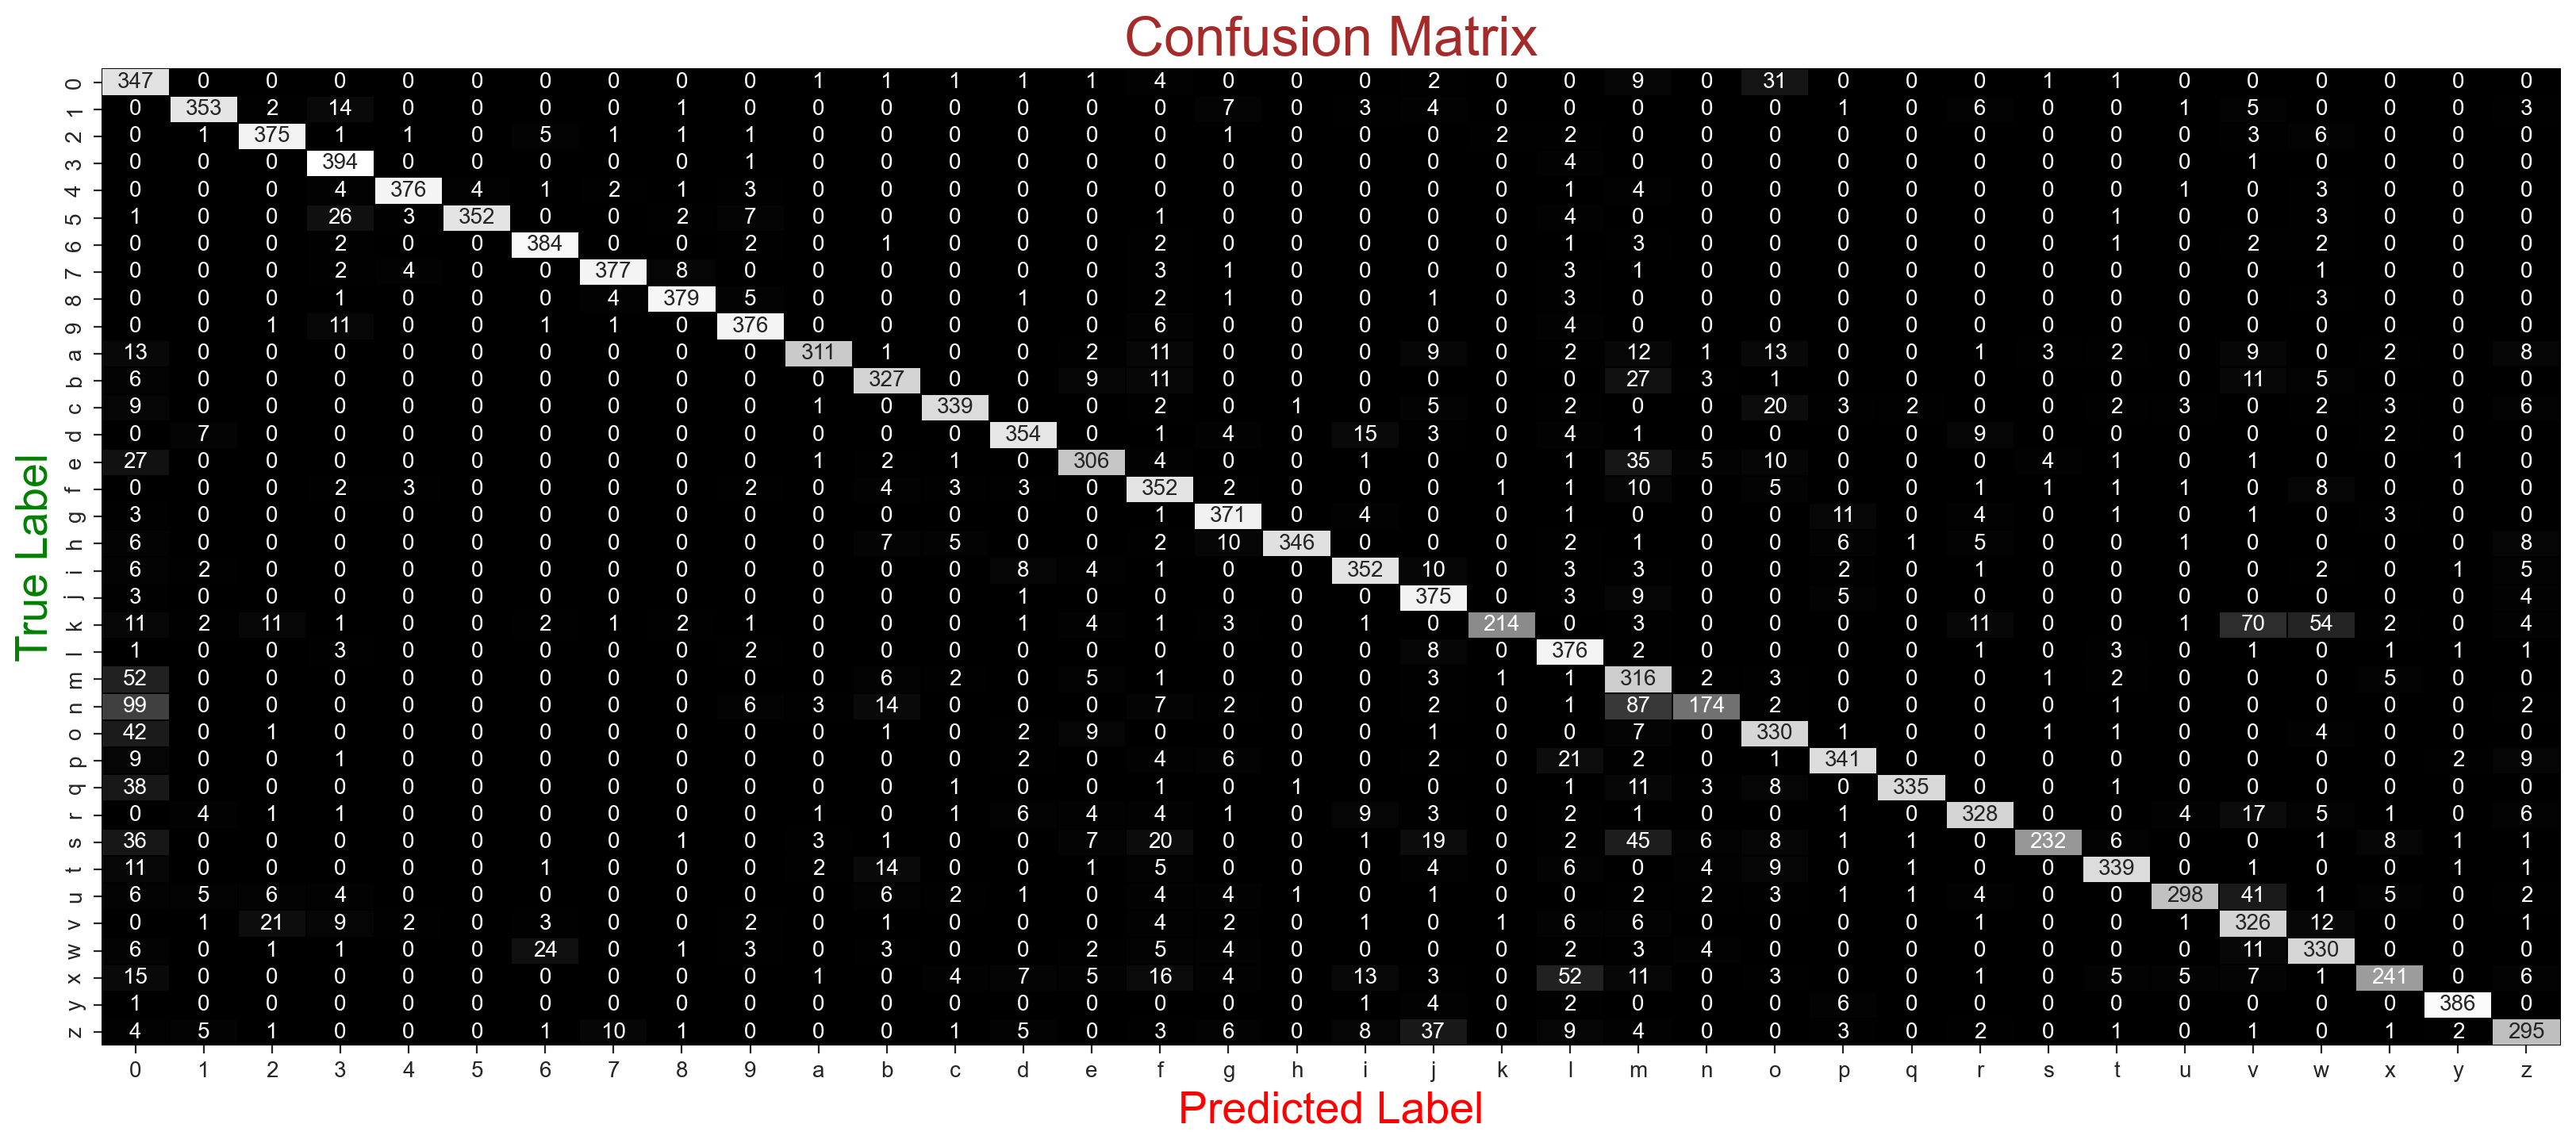

In [21]:
sns.set_style('ticks')

confusion_mtx = confusion_matrix(y_true,y_pred)

f,ax = plt.subplots(figsize = (20,8),dpi=200)

sns.heatmap(confusion_mtx, annot=True,
            linewidths=0.1, cmap = "gist_yarg_r",
            linecolor="black", fmt='.0f', ax=ax,
            cbar=False, xticklabels=categories.values(),
            yticklabels=categories.values())

plt.xlabel("Predicted Label",fontdict={'color':'red','size':20})
plt.ylabel("True Label",fontdict={'color':'green','size':20})
plt.title("Confusion Matrix",fontdict={'color':'brown','size':25})

plt.show()

In [22]:
# Save the model
model.save('ASL_ResNet50_model.h5')
from tensorflow.keras.models import load_model
#Load the ResNet model 
model = load_model("ASL_ResNet50_model.h5")

In [23]:
def remove_background(input_path, output_path):
    input_image = Image.open(input_path)
    # Assuming `remove` function removes the background and returns an RGBA image
    # You can convert it to RGB mode before saving
    output_image = remove(input_image)
    # Convert RGBA image to RGB mode
    output_image = output_image.convert("RGB")
    output_image.save(output_path)
    return output_image

def predict_class(model,img_path):
        
        img_no_bg_path = "temp_no_bg.jpg"  # Temporary file to store the image without background
        remove_background(img_path, img_no_bg_path)

        # Load and preprocess the image
        img_width, img_height = 200, 200
        image_no_bg = image.load_img( img_no_bg_path, target_size=(img_width, img_height))
        img_array = image.img_to_array(image_no_bg)

        img_array /= 255.0
        # Resize the image to match the model's input shape
        img_array_resized = resize(img_array, (img_width, img_height))


        # Expand dimensions to create a batch with a single image
        img_array_resized = np.expand_dims(img_array_resized, axis=0)

        # Make predictions
        predictions = model.predict(img_array_resized)

        # Print predicted class index
        predicted_class_index = np.argmax(predictions)
        print("Predicted class index:", predicted_class_index)
        return predicted_class_index

### Sample Predictions on Test Data

In [24]:
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.image import resize
from rembg import remove
from PIL import Image

img_path1='C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/Datasets/ASL_Data_Preprocessed/asl_data_test_processed/M/M61.jpg'
img_path2='C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/Datasets/ASL_Data_Preprocessed/asl_data_train_processed/B/B1284.jpg'
img_path3=r'C:\Users\ANBU NAMBI\Desktop\CSCI 6364\Project\Datasets\ASL_Data_Preprocessed\asl_data_test_processed\5\5 (14).png'
# model="ASL_Custom_model2.h5"
img_paths=[img_path1,img_path2,img_path3]

for img in img_paths:
    index= predict_class(model,img)
    print("Predicted sign:",categories[index])

1/1 [==============================] - 1s 1s/step
Predicted class index: 22
Predicted sign: m
1/1 [==============================] - 0s 33ms/step
Predicted class index: 11
Predicted sign: b
1/1 [==============================] - 0s 33ms/step
Predicted class index: 5
Predicted sign: 5


### Testing on unseen data

In [67]:
input_img = r"C:\Users\ANBU NAMBI\Desktop\CSCI 6364\Project\input_images\input_images\working\0.jpg"
index= predict_class(model,input_img)
print("Predicted sign:",categories[index])

1/1 [==============================] - 0s 19ms/step
Predicted class index: 0
Predicted sign: 0
